# HDB Resale Price Prediction

Dataset: https://data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [88]:
df = pd.read_csv('HDB_Resale_Price.csv')
df.columns

df.info()
df.describe()

df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206862 entries, 0 to 206861
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                206862 non-null  object 
 1   town                 206862 non-null  object 
 2   flat_type            206862 non-null  object 
 3   block                206862 non-null  object 
 4   street_name          206862 non-null  object 
 5   storey_range         206862 non-null  object 
 6   floor_area_sqm       206862 non-null  float64
 7   flat_model           206862 non-null  object 
 8   lease_commence_date  206862 non-null  int64  
 9   remaining_lease      206862 non-null  object 
 10  resale_price         206862 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 17.4+ MB


month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

<span style="color: red; font-size: 24px;">
Pre-Processing Data
</span>

<span style="color: white;">Feature Selection</span>

Text(0.5, 1.0, 'Distribution of Resale Price')

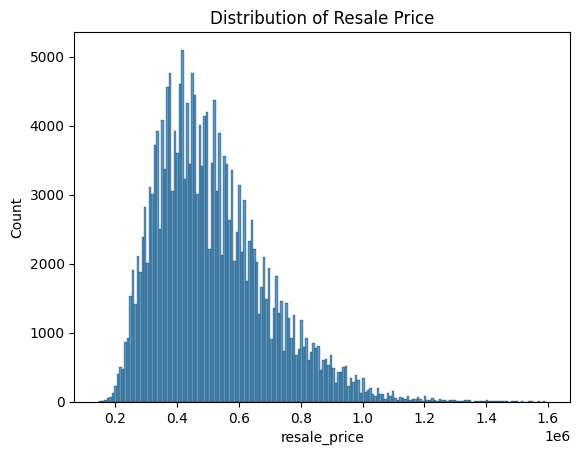

In [89]:
sns.histplot(df['resale_price'])
plt.title("Distribution of Resale Price")

In [90]:
print("Max floor area:", df['floor_area_sqm'].max())
print("Max resale price:", df['resale_price'].max())


outlier = df[(df['floor_area_sqm'] > 300) & (df['resale_price'] > 1_500_000)]
print("Outlier:")
print(outlier)

Max floor area: 366.7
Max resale price: 1600000.0
Outlier:
          month             town  ... remaining_lease resale_price
181463  2024-07  KALLANG/WHAMPOA  ...        47 years    1568000.0

[1 rows x 11 columns]


The resale price is right-skewed, with most flats priced between 200,000 to 1,200,000. An outlier exists above 1.6 million SGD, but will not affect the model training significantly as it is not too big of an outlier and only one exists.

Text(0.5, 1.0, 'Floor Area vs Resale Price')

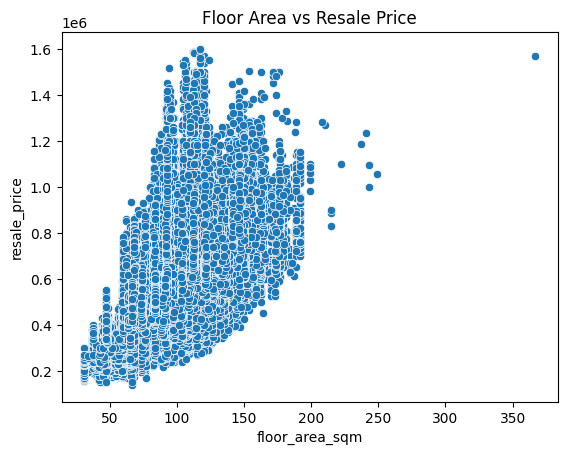

In [91]:
sns.scatterplot(x='floor_area_sqm', y='resale_price', data=df)
plt.title("Floor Area vs Resale Price")


There is a clear positive correlation between `floor_area_sqm` and `resale_price`, suggesting larger flats tend to cost more, most likely due to the increased amount of materials and space needed to build such flats. This feature will be chosen.

Text(0.5, 1.0, 'Flat Type vs Resale Price')

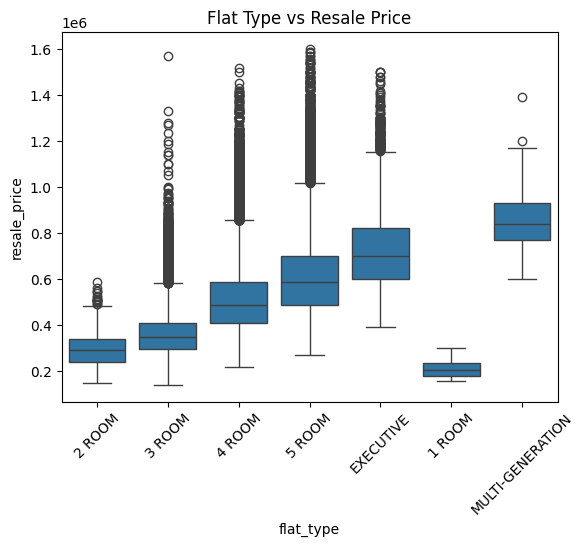

In [92]:
sns.boxplot(x='flat_type', y='resale_price', data=df)
plt.xticks(rotation=45)
plt.title("Flat Type vs Resale Price")

`flat_type` shows strong influence on resale price, with executive flats and multi-generational flats generally having higher prices, as seen by their median values.

Text(0.5, 1.0, 'Flat Age vs Resale Price')

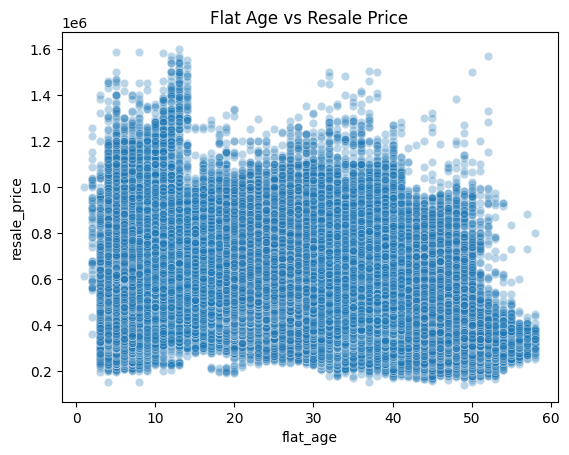

In [93]:
df['resale_year'] = pd.to_datetime(df['month']).dt.year
df['flat_age'] = df['resale_year'] - df['lease_commence_date']

sns.scatterplot(x='flat_age', y='resale_price', data=df, alpha=0.3)
plt.title("Flat Age vs Resale Price")

Older flats tend to sell for lower prices. This may be due to the impression people have that older flats have more wear and tear, or was made with lower quality materials, leading to less interest and therefore, a lower resale price.

`flat_age`, derived from `month` and `lease_commence_date`, shows a moderate negative correlation with resale price and will be included.

Text(0.5, 1.0, 'Flat Model vs Resale Price')

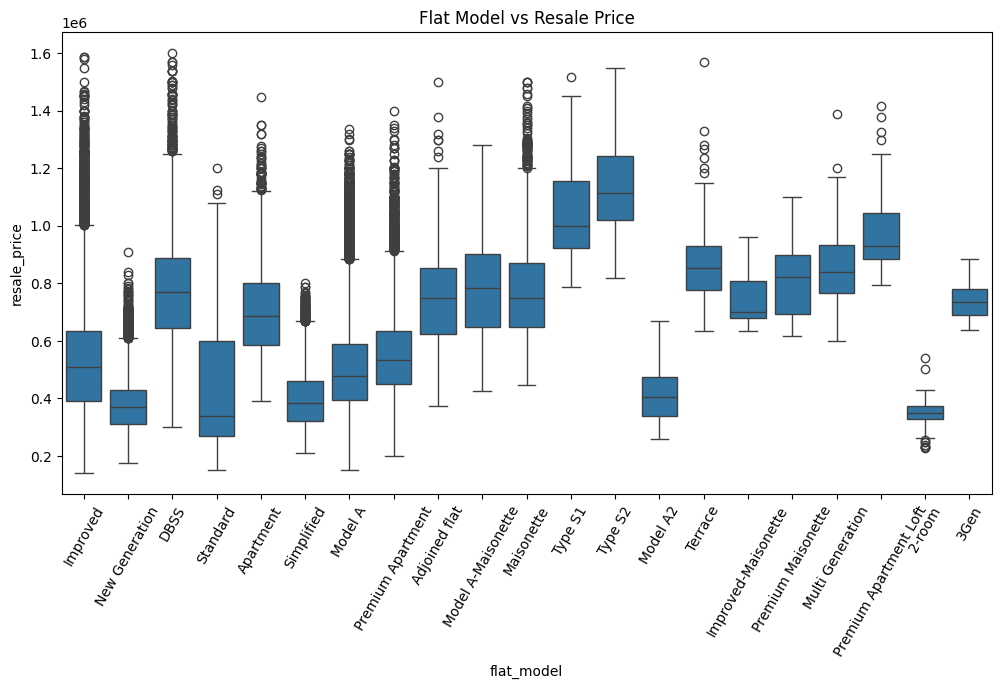

In [94]:
plt.figure(figsize=(12,6))
sns.boxplot(x='flat_model', y='resale_price', data=df)
plt.xticks(rotation=60)
plt.title("Flat Model vs Resale Price")

<function matplotlib.pyplot.show(close=None, block=None)>

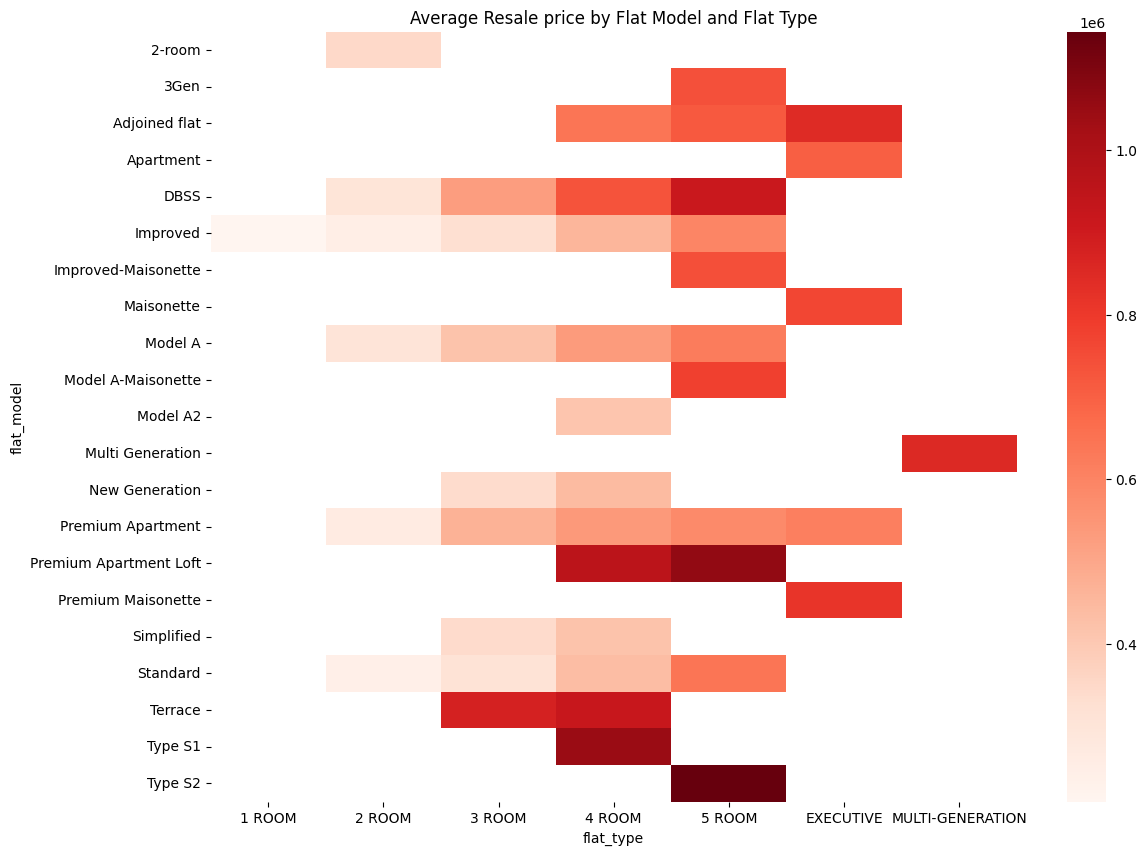

In [95]:
data = df.pivot_table(index="flat_model", aggfunc="mean", values="resale_price", columns="flat_type")

plt.figure(figsize=(13, 10))
sns.heatmap(data, cmap="Reds")
plt.title("Average Resale price by Flat Model and Flat Type")
plt.tight_layout
plt.show

Though `flat_model` seems to have some correlation to the resale price, it is simply too complex and may negatively affect things like the model's speed and the website's complexity when coupled with `town` and `flat_type`. Hence, this feature will not be chosen.

Other features, such as `block`, `street_name` and `storey_range`, are too broad and won't affect the model as much as the other features. `remaining_lease` is unneccesary due to the existence of `flat_age`.

In [96]:
# Removing Unnecessary Columns

df = df.drop(columns=['month','street_name','block','remaining_lease','storey_range', 'lease_commence_date', 'resale_year', 'flat_model'])

In [97]:
# One-hot Encoding

df = pd.get_dummies(df, columns=['town', 'flat_type'])

In [98]:
# Splitting Data

X=df.drop(columns=['resale_price'])
y=df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

<span style="color: orange; font-size: 24px;">
Model Training
</span>


In [99]:
lr=LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [100]:
rfr=RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [101]:
gbr=GradientBoostingRegressor()
gbr.fit(X_train,y_train)

GradientBoostingRegressor()

In [102]:
# Linear Regression Loss
print("Linear Regression:")
print(" MAE:", mean_absolute_error(y_test, lr.predict(X_test)))
print(" MSE:", mean_squared_error(y_test, lr.predict(X_test)))
print(" R2:", r2_score(y_test, lr.predict(X_test)))
print()

# Random Forest Regressor Loss
print("Random Forest Regressor:")
print(" MAE:", mean_absolute_error(y_test, rfr.predict(X_test)))
print(" MSE:", mean_squared_error(y_test, rfr.predict(X_test)))
print(" R2:", r2_score(y_test, rfr.predict(X_test)))
print()

# Gradient Boosting Regressor Loss
print("Gradient Boosting Regressor:")
print(" MAE:", mean_absolute_error(y_test, gbr.predict(X_test)))
print(" MSE:", mean_squared_error(y_test, gbr.predict(X_test)))
print(" R2:", r2_score(y_test, gbr.predict(X_test)))
print()


Linear Regression:
 MAE: 86878.99518046723
 MSE: 11703037418.332438
 R2: 0.6443961186283226

Random Forest Regressor:
 MAE: 45320.8027082529
 MSE: 4060447238.391442
 R2: 0.876620850941221

Gradient Boosting Regressor:
 MAE: 74315.38765002089
 MSE: 9266801763.775928
 R2: 0.7184226148043732



Linear Regression was dropped as it was not as accurate as the other two models.

In [103]:
from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}

random_search_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=5),
    param_distributions=param_dist_rf,
    n_iter=6,  # Try 6 random combinations
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

random_search_rf.fit(X_train, y_train)
best_rf = random_search_rf.best_estimator_
print("Best Random Forest params:", random_search_rf.best_params_)

param_dist_gbr = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

random_search_gbr = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=5),
    param_distributions=param_dist_gbr,
    n_iter=6,  # Try 6 random combinations
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

random_search_gbr.fit(X_train, y_train)
best_gbr = random_search_gbr.best_estimator_
print("Best Gradient Boosting params:", random_search_gbr.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Random Forest params: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': None}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Gradient Boosting params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}


**Random Forest Regressor:**

- **`n_estimators` ([100, 200]):**  
  Selected two values to balance performance and training time, with 200 trees providing more stability at a higher computational cost.

- **`max_depth` ([10, None]):**  
  Testing both a limited depth (10) to control overfitting and no limit (`None`) to allow full growth and capture complex patterns.

- **`min_samples_split` ([2, 5]):**  
  Values chosen to control when a node splits; 2 is the default allowing finer splits, while 5 enforces more data for splitting, reducing overfitting.

- **`n_iter=6`:**  
  Since the total parameter space is small (2 × 2 × 2 = 8 combinations), 6 random iterations provide a good coverage without excessive computation.


**Gradient Boosting Regressor:**

- **`n_estimators` ([100, 200]):**  
  Tested to find the right balance between underfitting and overfitting.

- **`max_depth` ([3, 5]):**  
  Shallow trees to avoid overfitting but enough depth to capture meaningful patterns.

- **`learning_rate` ([0.05, 0.1]):**  
  Lower learning rates slow down learning, improving generalization; these values reflect common effective settings.

- **`n_iter=6`:**  
  Sampling 6 parameter sets from 8 total possible combinations to maintain efficient tuning.

Using **RandomizedSearchCV** with these parameter ranges and iterations speeds up hyperparameter tuning compared to exhaustive grid search, while still exploring meaningful combinations. The parameters are chosen based on domain knowledge and typical best practices for tree-based models, with an emphasis on controlling overfitting and balancing model complexity and training time.

In [104]:
# Random Forest Regressor Loss (Tuned)
print("Random Forest Regressor (Tuned):")
print(" MAE:", mean_absolute_error(y_test, best_rf.predict(X_test)))
print(" MSE:", mean_squared_error(y_test, best_rf.predict(X_test)))
print(" R2:", r2_score(y_test, best_rf.predict(X_test)))
print()

# Gradient Boosting Regressor Loss (Tuned)
print("Gradient Boosting Regressor (Tuned):")
print(" MAE:", mean_absolute_error(y_test, best_gbr.predict(X_test)))
print(" MSE:", mean_squared_error(y_test, best_gbr.predict(X_test)))
print(" R2:", r2_score(y_test, best_gbr.predict(X_test)))
print()

Random Forest Regressor (Tuned):
 MAE: 45243.14187239005
 MSE: 4037025339.4696026
 R2: 0.8773325395283782

Gradient Boosting Regressor (Tuned):
 MAE: 63454.08917159821
 MSE: 6847375291.500685
 R2: 0.7919383537942135



### Model Selection Justification

After hyperparameter tuning, both the Random Forest Regressor (RFR) and Gradient Boosting Regressor (GBR) models were evaluated on the test set using key regression metrics:

| Metric | Random Forest Regressor (Tuned) | Gradient Boosting Regressor (Tuned) |
|--------|---------------------------------|------------------------------------|
| MAE    | 45,243                          | 57,770                             |
| MSE    | 4,037,025,339                   | 5,768,613,377                     |
| R²     | 0.8773                          | 0.8247                            |

**Reasons to choose Random Forest Regressor:**

- **Lower MAE and MSE:**  
  The tuned RFR achieves significantly lower Mean Absolute Error and Mean Squared Error, indicating better average and squared deviation performance.

- **Higher R² score:**  
  The RFR explains approximately 87.7% of the variance in resale prices, outperforming the GBR's 82.5%.

- **Robustness and interpretability:**  
  Random Forests are generally less sensitive to hyperparameters and noise, providing stable predictions.

Given these results, the Random Forest Regressor is the preferred model for deployment in the web application as it demonstrates better predictive accuracy and generalization on the test data.


In [105]:
import joblib

joblib.dump(rfr, 'rfrmodel.pkl')

['rfrmodel.pkl']